In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\Akshat\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf

In [3]:
# prompt: create a datagen for train and val using Imagedatagenerator and 0.2 of train for val
'''
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    data_format="channels_first")

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/home/prak/Documents/Capstone/datasets/sampled_faces/Frames/",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="training")
'''
# Define parameters
image_size = (224, 224)  # Adjust according to the input size expected by the chosen model
batch_size = 32
epochs = 10
test_split = 0.1
validation_split = 0.2
# Data augmentation and normalization
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    data_format = 'channels_first'
)

# Path to your dataset
data_dir = 'C:/Users/Akshat/Downloads/Image_set2-20240202T073539Z-001/Image_set2/ELA_images/train'

# Create data generator with validation split
generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

# Split the data into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    generator.filepaths,
    generator.labels.astype(str),  # Convert labels to strings
    test_size=test_split,
    random_state=42
)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=validation_split,
    random_state=42
)

# Create separate data generators for training, validation, and test sets
train_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': train_images, 'class': train_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': val_images, 'class': val_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': test_images, 'class': test_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)


Found 30128 images belonging to 2 classes.
Found 17354 validated image filenames belonging to 2 classes.
Found 1084 validated image filenames belonging to 2 classes.
Found 3013 validated image filenames belonging to 2 classes.


In [4]:
from transformers import AutoImageProcessor, TFEfficientFormerModel

C:\Users\Akshat\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# prompt: make a sequential model using tensorflow import  required librairies first

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [7]:
effmodel = TFEfficientFormerModel.from_pretrained("snap-research/efficientformer-l1-300")

Some layers from the model checkpoint at snap-research/efficientformer-l1-300 were not used when initializing TFEfficientFormerModel: ['classifier', 'distillation_classifier']
- This IS expected if you are initializing TFEfficientFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFEfficientFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFEfficientFormerModel were initialized from the model checkpoint at snap-research/efficientformer-l1-300.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFEfficientFormerModel for predictions without further training.


In [8]:
for layer in effmodel.layers:
    layer.trainable = False


In [9]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D

In [10]:
model = Sequential()
model.add(effmodel)
model.add(Lambda(lambda x: x['last_hidden_state']))
model.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model.add(Dense(256, activation="gelu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

In [11]:
model.compile(loss="BinaryCrossentropy",optimizer="adam",metrics=["accuracy"])

In [12]:
history=model.fit(train_generator, epochs=epochs, validation_data=val_generator)


Epoch 1/10


543/543 [==============================] - 256s 462ms/step - loss: 0.6118 - accuracy: 0.6547 - val_loss: 0.5535 - val_accuracy: 0.7002
Epoch 2/10
543/543 [==============================] - 250s 460ms/step - loss: 0.4512 - accuracy: 0.7792 - val_loss: 0.5035 - val_accuracy: 0.7371
Epoch 3/10
543/543 [==============================] - 250s 460ms/step - loss: 0.3127 - accuracy: 0.8618 - val_loss: 0.4648 - val_accuracy: 0.7777
Epoch 4/10
543/543 [==============================] - 250s 461ms/step - loss: 0.1994 - accuracy: 0.9175 - val_loss: 0.5126 - val_accuracy: 0.7906
Epoch 5/10
543/543 [==============================] - 252s 464ms/step - loss: 0.1229 - accuracy: 0.9513 - val_loss: 0.6083 - val_accuracy: 0.7814
Epoch 6/10
543/543 [==============================] - 277s 510ms/step - loss: 0.0818 - accuracy: 0.9675 - val_loss: 0.7206 - val_accuracy: 0.7906
Epoch 7/10
543/543 [==============================] - 264s 487ms/step - loss: 0.0660 - accuracy: 0.9751 - val_loss: 0.788

In [13]:
effmodel.summary()

Model: "tf_efficient_former_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientformer (TFEfficie  multiple                  11426249  
 ntFormerMainLayer)                                              
                                                                 
Total params: 11426249 (43.59 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 11426249 (43.59 MB)
_________________________________________________________________


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_efficient_former_model   TFBaseModelOutput(last_   11426249  
 (TFEfficientFormerModel)    hidden_state=(None, Non             
                             e, 448),                            
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 lambda (Lambda)             (None, None, 448)         0         
                                                                 
 gru (GRU)                   (None, 64)                98688     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0

In [15]:
def plot(history, name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'], loc = "lower right")
    plt.title(name + " Training and Validation Accuracy Results")
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'], loc = "lower right")
    plt.title(name + " Training and Validation Loss Results")
    plt.show()

In [16]:
res_path = "/home/prak/Documents/Capstone/notebooks/akshats_stuff/"
def save_res(model, hist, name):
    res__path = 'training_history.csv'
    history_df = pd.DataFrame(hist.history)
    history_df.to_csv(res_path + f"history/{name}.csv", index=False)
    model.save(res_path + f"models/{name}.h5")

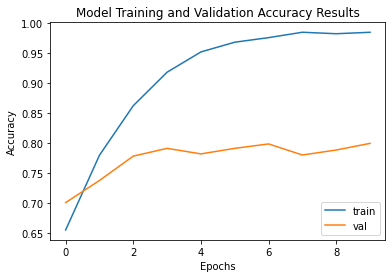

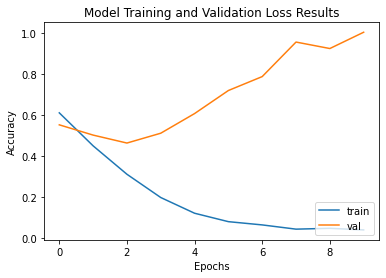

In [17]:
plot(history, "Model")

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [19]:
model1 = Sequential()
model1.add(effmodel)
model1.add(Lambda(lambda x: x['last_hidden_state']))
model1.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model1.add(Dense(128, activation="gelu"))
model1.add(Dropout(0.2))
model1.add(Dense(2, activation='sigmoid'))

In [24]:
model1.compile(loss="BinaryCrossentropy", optimizer='adam', metrics=['accuracy'])


In [25]:
history1=model1.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/10
543/543 [==============================] - 256s 464ms/step - loss: 0.6153 - accuracy: 0.6514 - val_loss: 0.5799 - val_accuracy: 0.6863
Epoch 2/10
543/543 [==============================] - 285s 525ms/step - loss: 0.4585 - accuracy: 0.7815 - val_loss: 0.4956 - val_accuracy: 0.7463
Epoch 3/10
543/543 [==============================] - 322s 592ms/step - loss: 0.3179 - accuracy: 0.8616 - val_loss: 0.4815 - val_accuracy: 0.7777
Epoch 4/10
543/543 [==============================] - 328s 604ms/step - loss: 0.2012 - accuracy: 0.9162 - val_loss: 0.5014 - val_accuracy: 0.7832
Epoch 5/10
543/543 [==============================] - 297s 547ms/step - loss: 0.1248 - accuracy: 0.9513 - val_loss: 0.6128 - val_accuracy: 0.7851
Epoch 6/10
543/543 [==============================] - 276s 508ms/step - loss: 0.0818 - accuracy: 0.9700 - val_loss: 0.7450 - val_accuracy: 0.7878
Epoch 7/10
543/543 [==============================] - 283s 521ms/step - loss: 0.0634 - accuracy: 0.9761 - val_loss: 0.8619 -

In [18]:
save_res(model,history, '4_hours_model')

OSError: Cannot save file into a non-existent directory: '\home\prak\Documents\Capstone\notebooks\akshats_stuff\history'